In [2]:
from time import time
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.scipy as jsp
import jax.tree_util as jtu
import jax.numpy as jnp

from itertools import product
from functools import partial
from scipy.io import savemat
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display_html
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

import optax


import matplotlib.pyplot as plt
import pandas as pd

from base import loss_fn, predict_fn, get_params
from utils import train_fn, latexify
from data import generate_heinonen_gp_data

jax.config.update("jax_enable_x64", True)

%reload_ext watermark

# Config

In [3]:
method = "delta_inducing"  # "heinonen" or "delta_inducing"
default_params = False
n_iters = 1000
lr = 0.005
n_restarts = 3

# Data

In [4]:
lower = 0
upper = 2*24

In [32]:
start_time = time()
aq_results = {}
idx = 0
for ell, sigma, omega in product([1,0], repeat=3):
    model_flex_dict = {"ell": ell, "sigma": sigma, "omega": omega}
    aq_results1 = aq_results[(ell, sigma, omega)] = {}
    for fold in range(3):
        print(f"(ell, sigma, omega) = {(ell, sigma, omega)}, fold = {fold}")
        aq_results2 = aq_results1[fold] = {}
        train_test_data = {"train": {}, "test": {}}
        for key in train_test_data:
            df = pd.read_csv(f"aq_data/{key}_fold{fold}.csv")
            df = df[(lower<df.delta_t) & (df.delta_t<=upper)]
            # print(train_df.columns, train_df.shape)
            X = jnp.asarray(df[['longitude', 'latitude', "temperature", "humidity", "delta_t"]].values)
            y = jnp.asarray(df['PM25_Concentration'].values)
            train_test_data[key]["X"] = X
            train_test_data[key]["y"] = y
        
        # Normalize
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(train_test_data["train"]["X"])
        X_test = x_scaler.transform(train_test_data["test"]["X"])
        
        y_train = train_test_data["train"]["y"]
        yscale = jnp.max(jnp.abs(y_train - jnp.mean(y_train)))
        ymean = jnp.mean(y_train)
        y_train = (y_train - ymean) / yscale
        y_test = (train_test_data["test"]["y"] - ymean) / yscale
        
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        value_and_grad_fn = partial(loss_fn, X=X_train, y=y_train, flex_dict=model_flex_dict, method=method)
        partial_get_params = partial(
            get_params, X=X_train, flex_dict=model_flex_dict, method=method, default=default_params
        )
        params = jax.vmap(partial_get_params)(jax.random.split(jax.random.PRNGKey(1000+idx), n_restarts))
        idx += 1
        partial_train_fn = partial(
            train_fn, loss_fn=value_and_grad_fn, optimizer=optax.adam(lr), n_iters=n_iters
        )
        
        # print(partial_train_fn(init_raw_params=jtu.tree_map(lambda x: x[0], params)))
        
        results = jax.vmap(partial_train_fn)(init_raw_params=params)
        
        # print("Losses: ", results["loss_history"][:, -1])
        best_idx = jnp.nanargmin(results["loss_history"][:, -1])
        result = jtu.tree_map(lambda x: x[best_idx], results)
        
        pred_mean, pred_var, pred_ell, pred_sigma, pred_omega = predict_fn(
            result["raw_params"],
            X_train,
            y_train,
            X_test,
            model_flex_dict,
            method,
        )
        
        aq_results2["pred_mean"] = pred_mean
        aq_results2["pred_var"] = pred_var
        aq_results2["pred_ell"] = pred_ell
        aq_results2["pred_sigma"] = pred_sigma
        aq_results2["pred_omega"] = pred_omega
        aq_results2["y_test"] = y_test
        aq_results2["X_test"] = X_test
        aq_results2["X_train"] = X_train
        aq_results2["y_train"] = y_train


print("Saving results...")
pd.to_pickle(aq_results, f"results/aq_results_{lower}_to_{upper}_{method}.pkl")
print("Time taken: ", (time() - start_time)/60, " minutes")

(ell, sigma, omega) = (1, 1, 1), fold = 0
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 1, 1), fold = 1
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 1, 1), fold = 2
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 1, 0), fold = 0
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 1, 0), fold = 1
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 1, 0), fold = 2
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 1), fold = 0
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 1), fold = 1
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 1), fold = 2
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 0), fold = 0
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 0), fold = 1
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (1, 0, 0), fold = 2
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (0, 1, 1), fold = 0
(960, 5) (960,) (480, 5) (480,)
(ell, sigma, omega) = (0, 1, 1), fold 

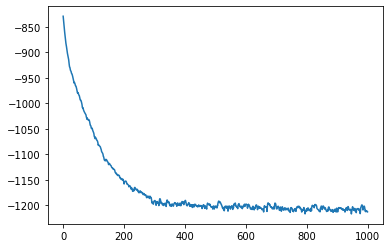

In [33]:
plt.plot(result["loss_history"]);

##### lr=0.001, iters=5000, restarts=10
* delta_inducing : 42 minutes
* heinonen: 79 minutes 

##### lr=0.005, iters=1000, restarts=3
* delta_inducing : 6 minutes
* heinonen:  minutes 

In [5]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Analysis

,0,1,2,mean
"(1, 1, 1)",0.1286,0.1559,0.1606,0.1484
"(1, 1, 0)",0.1030,0.1281,0.1823,0.1378
"(1, 0, 1)",0.1321,0.1300,0.1527,0.1383
"(1, 0, 0)",0.1291,0.1684,0.1766,0.1581
"(0, 1, 1)",0.1079,0.1138,0.1443,0.1220
"(0, 1, 0)",0.1006,0.1459,0.1798,0.1421
"(0, 0, 1)",0.0929,0.1168,0.1423,0.1173
"(0, 0, 0)",0.1010,0.1279,0.2000,0.1430
,0,1,2,mean
"(1, 1, 1)",6.0,7.0,4.0,7.0


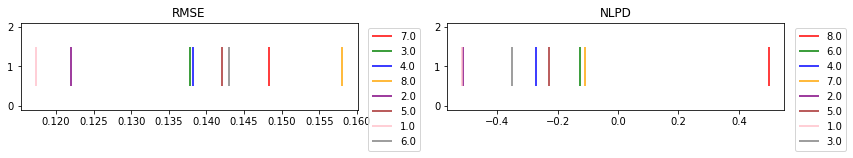

In [6]:
method = "delta_inducing" # "heinonen" or "delta_inducing"
lower = 0*24
upper = 2*24

aq_df = pd.read_pickle(f"results/aq_results_{lower}_to_{upper}_{method}.pkl")

rmse_df = pd.DataFrame(index=product([1, 0], repeat=3), columns=range(3))
nlpd_df = pd.DataFrame(index=product([1, 0], repeat=3), columns=range(3))
# rmse

for col in rmse_df.columns:
    for index in rmse_df.index:
        y_test = aq_df[index][col]["y_test"]
        pred_scale = jnp.sqrt(aq_df[index][col]["pred_var"] + aq_df[index][col]["pred_omega"]**2)
        pred_mean = aq_df[index][col]["pred_mean"]
        rmse_df[col][index] = jnp.sqrt(jnp.mean((y_test - pred_mean)**2 ))
        nlpd_df[col][index] = -jsp.stats.norm.logpdf(y_test, pred_mean, pred_scale).mean()
        
rmse_df["mean"] = rmse_df.mean(axis=1)
nlpd_df["mean"] = nlpd_df.mean(axis=1)

rmse_df_rank = rmse_df.rank()
nlpd_df_rank = nlpd_df.rank()

rmse_style = rmse_df.style.highlight_min(color='green').format("{:.4f}").set_table_attributes("style='display:inline'").set_caption("RMSE")
rmse_style_rank = rmse_df_rank.style.highlight_min(color='green').format("{:.1f}").set_table_attributes("style='display:inline'").set_caption("RMSE-rank")
nlpd_style = nlpd_df.style.highlight_min(color='green').format("{:.4f}").set_table_attributes("style='display:inline'").set_caption("NLPD")
nlpd_style_rank = nlpd_df_rank.style.highlight_min(color='green').format("{:.1f}").set_table_attributes("style='display:inline'").set_caption("NLPD-rank")

# display rmse_style and nlpd_style side by side
display_html(rmse_style._repr_html_()+rmse_style_rank._repr_html_()+nlpd_style._repr_html_()+nlpd_style_rank._repr_html_(), raw=True)

# convert above code to use two ax objects instead of two figures.
fig, ax = plt.subplots(1, 2, figsize=(12, 2));
colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
for i in range(len(rmse_df)):
    ax[0].eventplot(rmse_df["mean"].iloc[i].reshape(1), label=rmse_df_rank["mean"].iloc[i], colors=colors[i]);
ax[0].legend(bbox_to_anchor=(1.2, 1))
ax[0].set_title("RMSE");

for i in range(len(nlpd_df)):
    ax[1].eventplot(nlpd_df["mean"].iloc[i].reshape(1), label=nlpd_df_rank["mean"].iloc[i], colors=colors[i]);
ax[1].legend(bbox_to_anchor=(1.2, 1))
ax[1].set_title("NLPD");
fig.tight_layout();

In [162]:
plt.rc("animation", html="jshtml")
chk = pd.read_csv(f"aq_data/train_fold0.csv")
x_p = "humidity"
y_p = "PM25_Concentration"
tmp_lower = 1
tmp_upper = 2*24
df_range = chk[(tmp_lower<=chk.delta_t)&(tmp_upper>=chk.delta_t)]
y_min, y_max = df_range[y_p].min(), df_range[y_p].max()
x_min, x_max = df_range[x_p].min(), df_range[x_p].max()
print(x_min, x_max, y_min, y_max)

fig, ax = plt.subplots(1, 1)
def update(i):
    ax.cla()
    tmp = chk[chk.delta_t==i]
    idx = tmp[x_p].values.argsort()
    ax.plot(tmp[x_p].values[idx], tmp[y_p].values[idx], "-o")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

i_range = jnp.arange(tmp_lower, tmp_upper+1)

ani = FuncAnimation(fig, update, frames=i_range)

plt.close()
ani

10.0 92.0 3.0 327.0
